Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or elise or stephan, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [78]:
NAMES = "Dimitris Loupas"

---

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

#%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [80]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

Type:        GridworldEnv
String form: <GridworldEnv instance>
File:        ~/Desktop/RL_UVA/gridworld.py
Docstring:  
Grid World environment from Sutton's Reinforcement Learning book chapter 4.
You are an agent on an MxN grid and your goal is to reach the terminal
state at the top left or the bottom right corner.

For example, a 4x4 grid looks as follows:

T  o  o  o
o  x  o  o
o  o  o  o
o  o  o  T

x is your position and T are the two terminal states.

You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
Actions going off the edge leave you in your current state.
You receive a reward of -1 at each step until you reach a terminal state.


In [6]:
# To have a quick look into the code
??env

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [7]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [81]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)

    while True:
        delta = 0
        for s in range(env.nS):
            vold = V[s]
            vnew = 0
            for a in range(env.nA):
                prob = env.P[s][a][0][0]
                reward = env.P[s][a][0][2]
                next_state = env.P[s][a][0][1]
                vnew=vnew + policy[s][a]*prob*(reward+discount_factor*V[next_state])
            V[s] = vnew
            delta = max(delta, abs(vold-V[s]))
            #print(vold, vnew)
        if delta<theta:
            break
    
    return np.array(V)

In [82]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V

array([  0.        , -13.99993529, -19.99990698, -21.99989761,
       -13.99993529, -17.9999206 , -19.99991379, -19.99991477,
       -19.99990698, -19.99991379, -17.99992725, -13.99994569,
       -21.99989761, -19.99991477, -13.99994569,   0.        ])

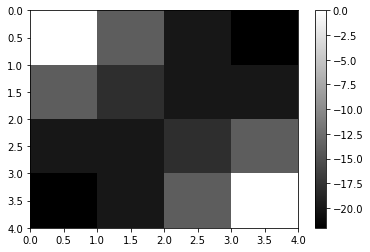

In [83]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [50]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [91]:
def policy_improvement(env,policy_eval=policy_eval ,discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    #V = policy_eval(policy, env, discount_factor)
    
    
    while True:
        V = policy_eval(policy, env, discount_factor)
        
        #policy impovement
        policy_stable = True
        for s in range(env.nS):
            old_action = policy[s]
            Max = float('-inf')
            argmax = 0
            for a in range(env.nA):
                prob = env.P[s][a][0][0]
                reward = env.P[s][a][0][2]
                next_state = env.P[s][a][0][1]
                temp = prob*(reward+discount_factor*V[next_state])
                #print(temp)
                if temp>Max:
                    Max = temp
                    argmax = a
            policy[s] = policy[s]*0.
            policy[s,argmax] = 1.
            #print(argmax)
            if np.any(old_action != policy[s]):
                policy_stable = False
    
    
        if policy_stable:
            V = policy_eval(policy, env, discount_factor) #value function for best policy
            break
    
    return policy, V

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 3]
 [0 0 3 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<<
^^<v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



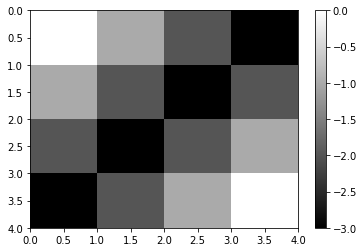

In [92]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [ ]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [105]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    
    V = np.zeros(env.nS)
    #V_actions = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA]) 
    while True:
        delta = 0
        for s in range(env.nS):
            vold = V[s]
            Vmax = float('-inf')
            argmax = 0
            for a in range(env.nA):
                prob = env.P[s][a][0][0]
                reward = env.P[s][a][0][2]
                next_state = env.P[s][a][0][1]
                temp = prob*(reward+discount_factor*V[next_state])
                if temp>Vmax:
                    Vmax = temp
                    argmax = a
            V[s] = Vmax
            policy[s] =policy[s]*0
            policy[s,argmax] = 1.
            delta = max(delta, abs(vold-V[s]))
        
        if delta<theta:
            break
            
    return policy, V

In [106]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

Policy iteration algorithm first evaluates the values function using policy evaluation and then uses policy improvent to find the best policy and this repeats until the calculated policy does not change any more. On the other hand in the value iteration algorithm the update rule combines both policy improvement and truncated policy evaluation steps. In the algorithm we have a max over actions in place of an expectation under a given policy. This max over actions means that we take an expectation under the current greedy policy. Henve, value iteration performs one sweep of policy evaluation under the current greedy policy, after which the greedy policy might change depending on what the values are after the sweep.

Value iteration is more efficient in terms of memory usage and number of updates (backup operations) executed but the policy is only extracted when the value function convergences. On the other hand in policy iteration we check at every iteration (after policy evaluation and policy improvement) if the policy is converged and sometimes this is faster than value iteration.

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

Dynamic-Programming needs a full description of the enviroment requiring knowledge of the transition probabilities $p(s^{'},r|s,a)$, whereas MC do not need it, they learn from samples of rewards interacting directly with the environment. Also DP uses bootstrap whereas MC don't.

Dynamic-Programming  is useful when the knowedge of the enviroment is available and Monte-Carlo when it is not. However for lagre state spaces storing the full distribution may require large amount of memory to use DP and we can instead use MC methods to sample the dynamics, because it is more efficient.

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [1]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [6]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [7]:
# We can also look at the documentation/implementation of a method
?env.step

In [5]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [434]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    
    return int(observation[0] < 20)

In [435]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(12, 10, False)
((22, 10, False), -1, True, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [436]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float) #empty dict
    
    
    
    for i in tqdm(range(num_episodes)):
        
        #Generate and episode
        init_s = env.reset() #init state
        action = policy(init_s) #action
        observation, reward, done, info = env.step(action)
        episode = [(init_s, reward)] #S0,R1
        
        while(done == False): #if episode not done generate the rest S,R pairs
            last_obs = observation
            action = policy(observation) 
            observation, reward, done, info = env.step(action)
            episode.append((last_obs, reward))
    
    
        G = 0 #init return to 0
        #calculate the reward G for each state encountered
        for state, R in reversed(episode):
            G = discount_factor*G + R
            
            returns_sum[state] = returns_sum[state] + G
            returns_count[state] = returns_count[state] + 1
            V[state] = returns_sum[state]/returns_count[state]
    
    return V

In [437]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
print(V)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 6809.52it/s]

defaultdict(<class 'float'>, {(16, 4, False): -1.0, (19, 10, False): -0.7288135593220338, (20, 1, True): 0.3333333333333333, (21, 3, False): 1.0, (14, 3, False): -0.45454545454545453, (13, 7, False): -0.5714285714285714, (18, 9, False): -0.42857142857142855, (13, 9, False): -0.1, (12, 9, False): -0.45454545454545453, (18, 5, False): -0.8, (12, 5, False): -1.0, (18, 10, False): -0.6976744186046512, (19, 5, False): -0.8666666666666667, (21, 10, True): 0.95, (15, 7, False): -0.75, (14, 1, False): -0.7272727272727273, (15, 1, True): -0.75, (20, 2, False): 0.8333333333333334, (21, 5, True): 0.8461538461538461, (20, 10, False): 0.38235294117647056, (17, 10, False): -0.7647058823529411, (20, 3, False): 0.9090909090909091, (19, 3, False): -0.5454545454545454, (15, 1, False): -0.6666666666666666, (19, 6, False): -0.8181818181818182, (18, 6, False): -1.0, (19, 5, True): -1.0, (13, 5, True): -1.0, (20, 4, False): 0.8461538461538461, (21, 6, True): 1.0, (17, 5, False): -1.0, (15, 5, False): -0.888

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [438]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|█████████████████████████████████| 500000/500000 [01:11<00:00, 6974.51it/s]

CPU times: user 1min 11s, sys: 521 ms, total: 1min 11s
Wall time: 1min 13s


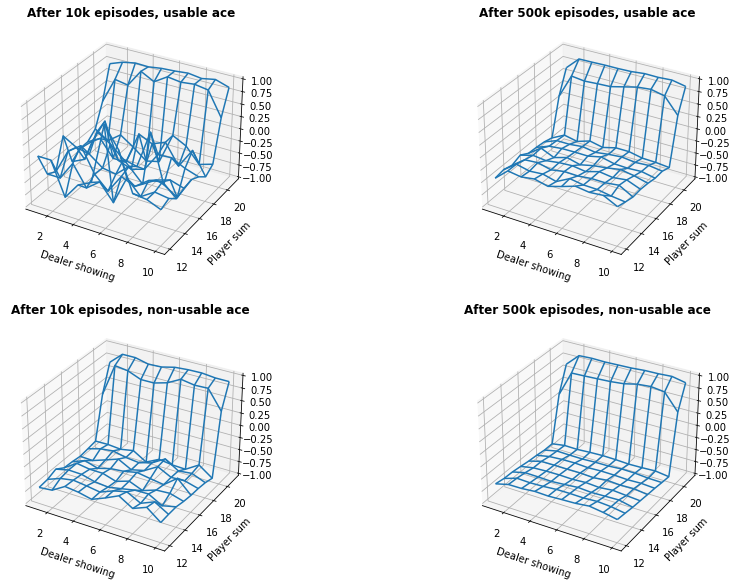

In [449]:
#plotting
from mpl_toolkits import mplot3d



zAce10k = np.zeros((10,10))
zNoAce10k = np.zeros((10,10))
zAce500k = np.zeros((10,10))
zNoAce500k = np.zeros((10,10))

for (x,y,ace) in V_10k:
    
    if ace==True:
        zAce10k[x-12][y-1] = V_10k[(x,y,ace)]
    else: 
        zNoAce10k[x-12][y-1] = V_10k[(x,y,ace)]
        



for (x,y,ace) in V_500k:
    
    if ace==True:
        zAce500k[x-12][y-1] = V_500k[(x,y,ace)]
    else:
        zNoAce500k[x-12][y-1] = V_500k[(x,y,ace)]
 

zlist = [zAce10k, zAce500k, zNoAce10k, zNoAce500k]

X, Y = np.meshgrid(np.arange(1,11), np.arange(12,22))
titles = ["After 10k episodes, usable ace","After 500k episodes, usable ace",
         "After 10k episodes, non-usable ace","After 500k episodes, non-usable ace"]


plot_number = 0 
for z in zlist: 
        plot_number += 1
        ax = plt.subplot(int(str(22) + str(plot_number)),projection='3d')
        ax.set_title(titles[plot_number-1],fontsize=12,fontweight = "bold");
        ax.set_ylabel('Player sum')
        ax.set_xlabel('Dealer showing')
        ax.set_zlim3d(-1, 1)
        ax.plot_wireframe(X, Y, z)
        #im = ax.plot_surface(X, Y, z)
        
plt.show()        

## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy.

In [466]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    
    def policy_fn(observation):
        argmax = np.argmax(Q[observation]) #max action value index
        probs = epsilon/nA*np.ones(nA)
        probs[argmax] = 1 - epsilon + epsilon/nA
        return probs
    return policy_fn

In [461]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #for each state 2 action hit or stick
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n) #policy for give Q
    
    
    for i in tqdm(range(num_episodes)):
    
        #generate an episode
        init_s = env.reset() #init state
        action_probs = policy(init_s) #action eg 2 actions [0.95, 0.05]
        action = np.argmax(np.random.multinomial(1, action_probs)) #choose action from the prob dist of available actions
        observation, reward, done, info = env.step(action)
        episode = [(init_s, action,reward)] #S0,A0,R1
        
        while(done == False): #if episode not done generate the rest S,A,R pairs
            last_obs = observation
            action_probs = policy(observation) 
            action = np.argmax(np.random.multinomial(1, action_probs)) 
            observation, reward, done, info = env.step(action)
            episode.append((last_obs, action, reward))
            
         
        G = 0 #init return to 0
        #calculate the reward G for each state encountered
        for state, action, R in reversed(episode):
            #print(action)
            G = discount_factor*G + R
            
            returns_sum[state][action] = returns_sum[state][action] + G #{state}:2d array of actions -> puts G value in the action taken
            returns_count[state][action] = returns_count[state][action] + 1
            Q[state][action] = returns_sum[state][action]/returns_count[state][action] #update Q values
    
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n) #policy for the new Q values
        
    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)
    

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4431.85it/s]


In [462]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|█████████████████████████████████| 500000/500000 [02:02<00:00, 4083.49it/s]

CPU times: user 2min, sys: 3.21 s, total: 2min 3s
Wall time: 2min 2s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

In [463]:
#V(s) = max_a q(s,a)
#P(s) = argmax_a q(s,a)

V = defaultdict(float)
P = defaultdict(int)
for state in Q:
    V[state] = max(Q[state])
    P[state] = np.argmax(Q[state])

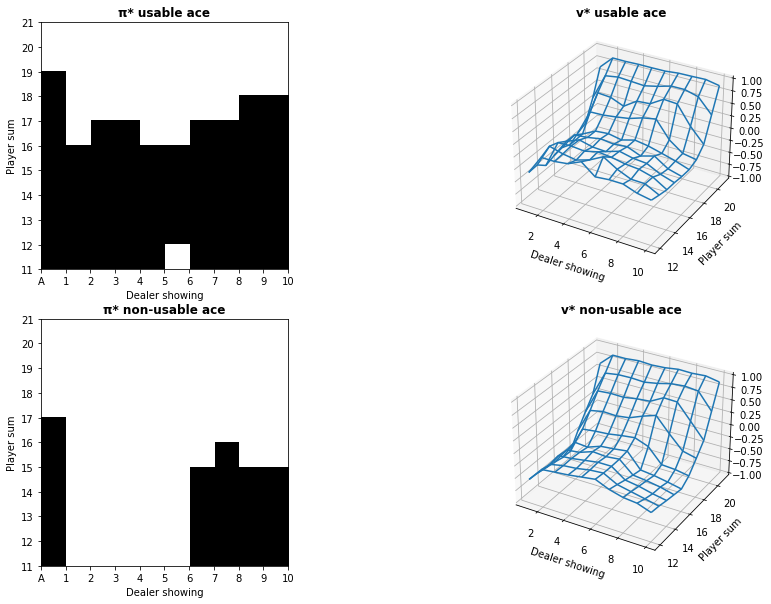

In [464]:


valueAce = np.zeros((10,10))
valueNoAce = np.zeros((10,10))
policyAce = np.zeros((10,10))
policyNoAce = np.zeros((10,10))

for (x,y,ace) in V:
    
    if ace==True:
        valueAce[x-12][y-1] = V[(x,y,ace)]
    else:
        valueNoAce[x-12][y-1] = V[(x,y,ace)]

for (x,y,ace) in P:
    
    if ace==True:
        policyAce[x-12][y-1] = P[(x,y,ace)]
    else:
        policyNoAce[x-12][y-1] = P[(x,y,ace)]
 

zlist = [policyAce, valueAce, policyNoAce, valueNoAce]

X, Y = np.meshgrid(np.arange(1,11), np.arange(12,22))
titles = ["π* usable ace","v* usable ace","π* non-usable ace","v* non-usable ace"]


plot_number = 0 
for z in zlist: 
        plot_number += 1
        #ax.set_zlim3d(-1, 1)
        if (plot_number-1)%2 == 0:
            ax = plt.subplot(int(str(22) + str(plot_number)))
            ax.set_title(titles[plot_number-1],fontsize=12,fontweight = "bold");
            ax.set_ylabel('Player sum')
            ax.set_xlabel('Dealer showing')
            ax.set_xticks(np.arange(-.5, 10, 1))
            ax.set_xticklabels(["A","1","2","3","4","5","6","7","8","9","10"])
            ax.set_yticks(np.arange(-.5, 10, 1))
            ax.set_yticklabels(["11","12","13","14","15","16","17","18","19","20","21"])
            ax.imshow(z, cmap='Greys',origin ='lower')
        else:
            ax = plt.subplot(int(str(22) + str(plot_number)),projection='3d')
            ax.set_title(titles[plot_number-1],fontsize=12,fontweight = "bold");
            ax.set_ylabel('Player sum')
            ax.set_xlabel('Dealer showing')
            ax.plot_wireframe(X, Y, z) #ax.plot_surface(X, Y, z)
            ax.set_zlim3d(-1, 1)
            
        
plt.show()        

## 6. Temporal Difference (TD) learning (8 points)
Mention one advantage and one disadvantage of Monte Carlo methods. Mention an example where you would prefer to use TD learning.

One advantage of MC method is that learn's directly from raw experience (interaction with the environment) without the need of a model for the environment dynamics. One disadvantage of MC is that we must wait until the end of an episode to update value (action-value) function estimates and policy updates, this is not useful for online learning.

We would prefer TD learning would be prefered in the case were episodes are very long because using TD learning we learn from each transition. An exampe will be the training a robot to walk, for this task TD learning will be more effiecient to use rather MC because the episode may last a long time.

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. In other words: implement SARSA. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [465]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 367.87it/s]


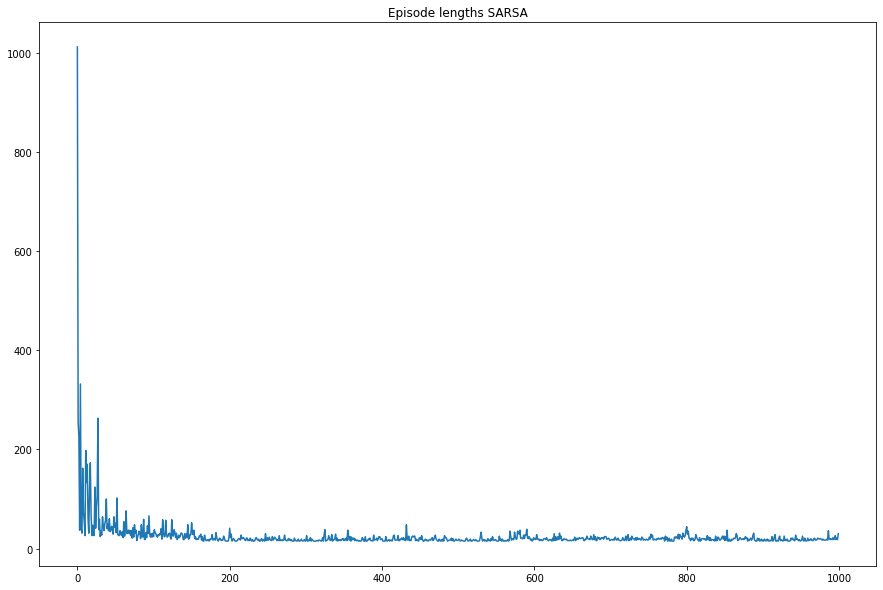

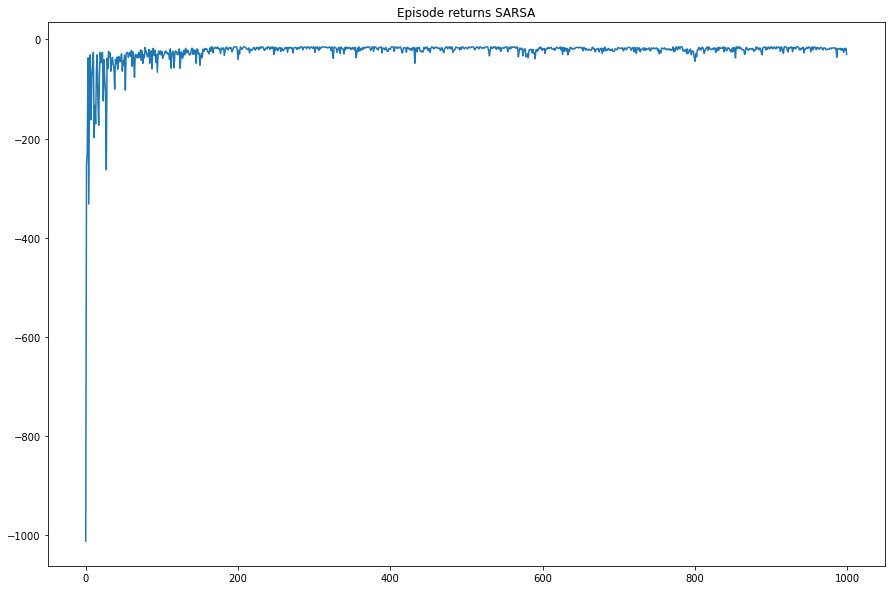

In [478]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n)) #for each state 4 actions u d r l
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    
    for i in tqdm(range(num_episodes)):
        ep_length = 0
        ep_return = 0
        
        S = env.reset()  #starting state
        A_probs = policy(S) 
        A = np.argmax(np.random.multinomial(1, A_probs)) #choose action from the prob dist of available actions
    
        done = False
        while(done == False):
            
            
            
            S_prime, reward, done, info = env.step(A)
            A_p_probs = policy(S_prime) 
            A_prime = np.argmax(np.random.multinomial(1, A_p_probs)) #new action A'
            Q[S][A] = Q[S][A] + alpha * (reward + discount_factor * Q[S_prime][A_prime] - Q[S][A])
            S = S_prime
            A = A_prime
            
            ep_length += 1
            ep_return += reward
            
        stats.append((ep_length, ep_return)) 
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_sarsa)
plt.title('Episode lengths SARSA')
plt.show()
plt.plot(episode_returns_sarsa)
plt.title('Episode returns SARSA')
plt.show()

Since we might not be interested in falling off the cliff all the time, we can find another person to do this 'exploration' for us (in the name of science). Still, we would like to learn ourselfs from this persons policy, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 415.70it/s]


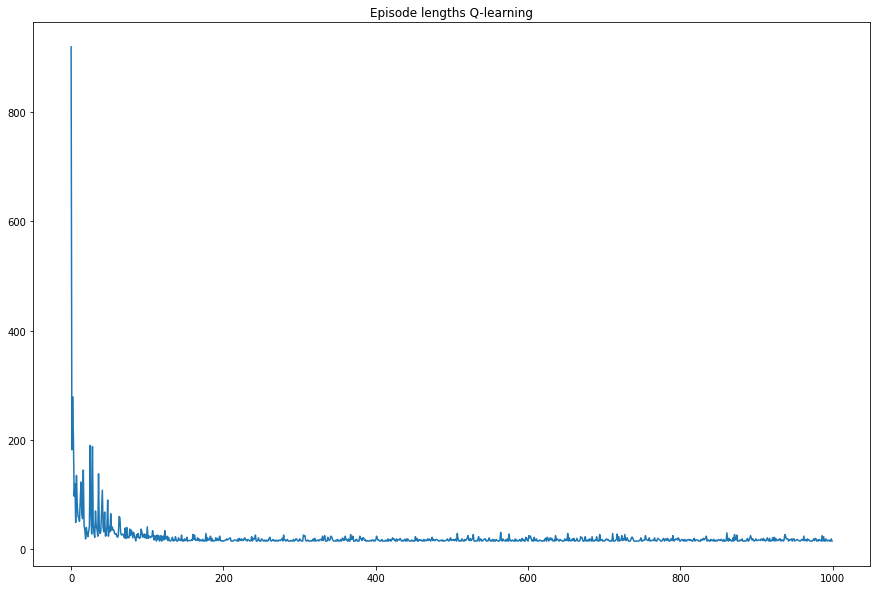

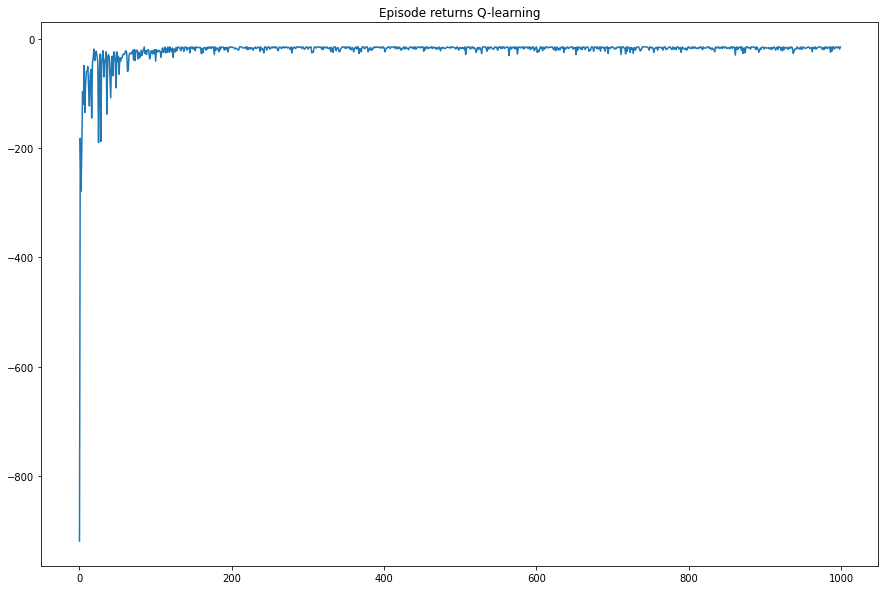

In [502]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        ep_length = 0
        ep_return = 0
        
        S = env.reset()  #starting state
        
        done = False
        while(done == False):
            
            A_probs = policy(S) 
            A = np.argmax(np.random.multinomial(1, A_probs)) #choose action from the prob dist of available actions
            
            
            S_prime, reward, done, info = env.step(A)
            
            Q[S][A] = Q[S][A] + alpha * (reward + discount_factor * max(Q[S_prime]) - Q[S][A])
            S = S_prime
            
            ep_length += 1
            ep_return += reward
        
        stats.append((ep_length, ep_return))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

Now compare the episode returns while learning for Q-learning and Sarsa (maybe run some more iterations?), by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, you may want to zoom in on the y-axis and smooth the returns (e.g. plotting the $n$ episode average instead). Which algorithm achieves higher return during learning? How does this compare to Example 6.6 from the book? Try to explain your observations.

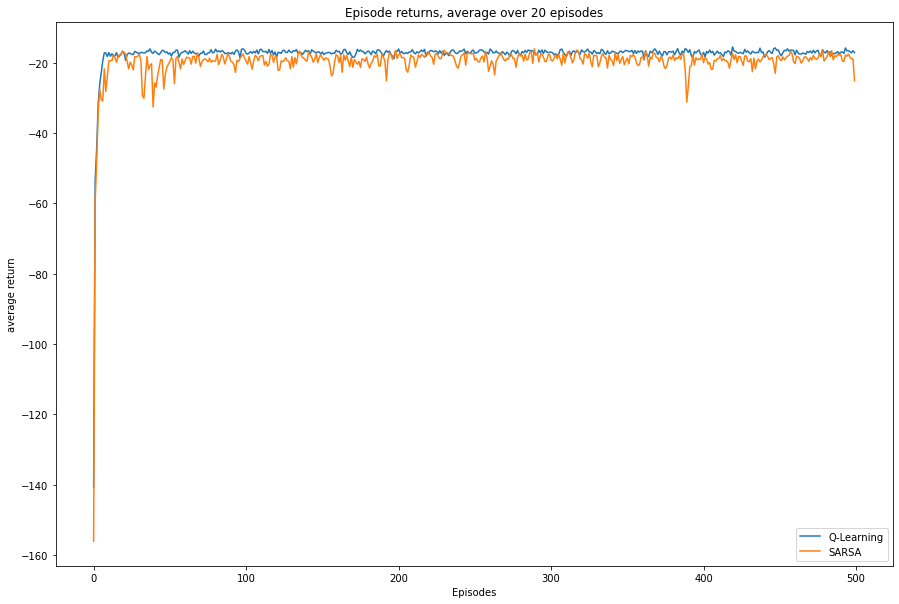

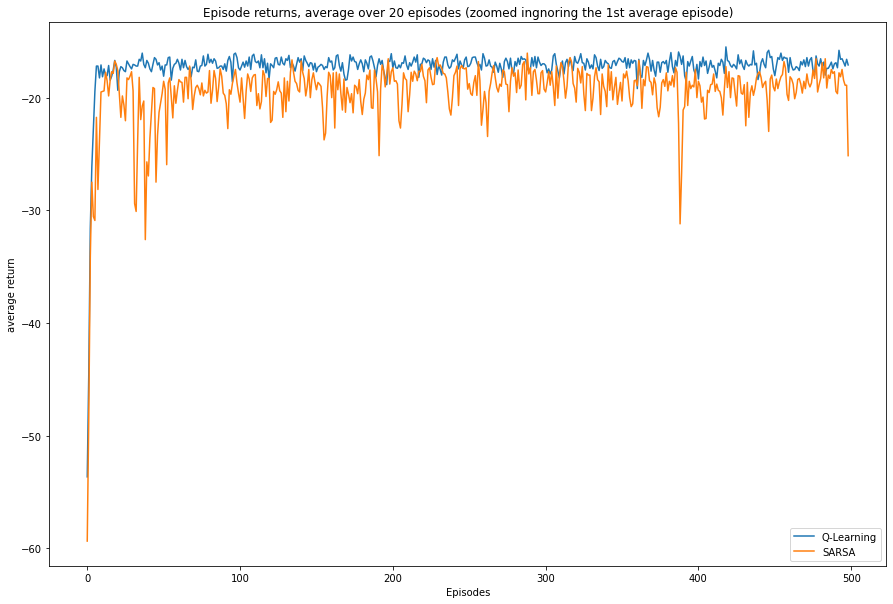

In [522]:
_, (_, episode_returns_sarsa) = sarsa(env, 10000)
_, (_, episode_returns_q_learning) = q_learning(env, 10000)

avg_rewards_q = np.array(episode_returns_q_learning).reshape(-1, 20).mean(1)
avg_rewards_sarsa = np.array(episode_returns_sarsa).reshape(-1, 20).mean(1)

plt.plot(avg_rewards_q, label='Q-Learning')
plt.plot(avg_rewards_sarsa, label='SARSA')
plt.title('Episode returns, average over 20 episodes')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('average return')
plt.show()

plt.plot(avg_rewards_q[1:], label='Q-Learning')
plt.plot(avg_rewards_sarsa[1:], label='SARSA')
plt.title('Episode returns, average over 20 episodes (zoomed ingnoring the 1st average episode)')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('average return')
plt.show()

The results are in agreement with the Example 6.6 from the book. Q-learning obtains greater rewards than Sarsa during learning. This result can be explained because Sarsa is on policy method whereas Q-learning is off policy method. The book has a different result because the Q-learning $\epsilon$-greedy policy sometimes causes the agent to fall in the cliff resulting in more negative reward.

After we have learned the policy, we do not care about exploration any more and we may switch to a deterministic (greedy) policy instead. If we evaluate this for both Sarsa and Q-learning (actually, for Q-learning the learned policy is already deterministic), which policy would you expect to perform better? Why?

We expect Q-learning to perform better because is an off policy method and directly finds the optimal greedy policy. On the other hand SARSA is on policy and finds an optimal $\epsilon$-greedy policy. Making this deterministic will result in sub-optimal greedy policy.


Please run the experiments to test your hypothesis (print or plot your results). How many runs do you need to evaluate the policy? Note: without learning, the order of the episodes is not relevant so a normal `plt.plot` may not be the most appropriate choice.

1 run to evaluate the policy because is deterministic.


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 388.36it/s]




Mean and std trining for 100 episodes and  10 experiments:
Sarsa: Mean =  -22.8 , Std =  5.287721626560915
Q-learning:      Mean =  -20.7 , Std =  4.817675788178362


Mean and std trining for 1000 episodes and  10 experiments:
Sarsa: Mean =  -16.8 , Std =  1.4696938456699067
Q-learning:      Mean =  -15.0 , Std =  0.0


Mean and std trining for 10000 episodes and  10 experiments:
Sarsa: Mean =  -15.8 , Std =  0.9797958971132712
Q-learning:      Mean =  -15.0 , Std =  0.0


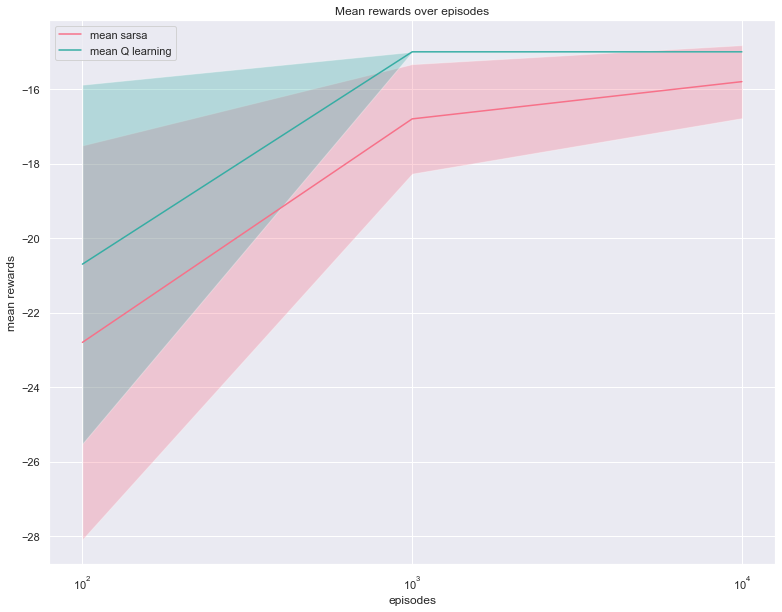

In [572]:
#1 run to evaluate the policy because in deterministic

num_episodes = [100, 1000, 10000]
runs = 10 #number of runs per number of episodes to take the average

mean_sarsa = np.zeros((len(num_episodes))) #init matrices
mean_q_learning = np.zeros((len(num_episodes)))

std_sarsa = np.zeros((len(num_episodes)))
std_q_learning = np.zeros((len(num_episodes)))


#run for number of episodes a number of experiments and take mean reward and std for given num_episodes
for ind, episodes in enumerate(num_episodes):
    reward_s = np.zeros((runs))
    reward_q = np.zeros((runs))
    for run in range(runs):
        
        #training to find Q
        Q_sarsa, _ = sarsa(env, episodes)
        Q_q_learning, _ = q_learning(env, episodes)
       
        #run an episode and get reward for deterministic policy 
        _, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1, epsilon=0, Q=Q_sarsa)
        _, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1, epsilon=0, Q=Q_q_learning)
        reward_s[run] = episode_returns_sarsa[0]
        reward_q[run] = episode_returns_q_learning[0]
    
    #store means and stds
    mean_sarsa[ind] = np.mean(reward_s)
    mean_q_learning[ind] =  np.mean(reward_q)
    std_sarsa[ind] = np.std(reward_s)
    std_q_learning[ind] = np.std(reward_q)

    
#print statistics
for ind, episodes in enumerate(num_episodes):
    print('\n\nMean and std trining for', episodes, 'episodes and ', runs, 'experiments:')
    print('Sarsa: Mean = ', mean_sarsa[ind], ', Std = ', std_sarsa[ind])
    print('Q-learning:      Mean = ', mean_q_learning[ind], ', Std = ', std_q_learning[ind])


import seaborn as sns
#Plot mean and std in a graph

means = [mean_sarsa, mean_q_learning] 
stds = [std_sarsa, std_q_learning]

string = ["sarsa", "Q learning"]
sns.set_theme()

fig, ax = plt.subplots( figsize=(13, 10))
ax.set_title('Mean rewards over episodes')
clrs = sns.color_palette("husl", 2)
with sns.axes_style("darkgrid"):
    for i in range(len(means)):
        ax.plot(num_episodes, means[i], label= "mean " + string[i],c=clrs[i])
        ax.fill_between(num_episodes, means[i]-stds[i], means[i]+stds[i] ,alpha=0.3, facecolor=clrs[i])
    ax.legend()
    ax.set_xlabel('episodes')
    ax.set_ylabel('mean rewards')
    plt.xscale('log')
    plt.show()


As we see the results match our expectations that Q-Learning converges to the optimal policy, whereas SARSA always has an std in the mean reward, dictating that a much larger number of episodes required to achive the optimal greedy policy. This happens because SARSA learns the optimal action value function of an $\epsilon$-greedy policy, resulting in a sub-optimal greedy policy.